In [41]:
import os
import sys
from pathlib import Path

cwd_path = cwd_path = Path(os.getcwd()).absolute().parents[0]
parent_path = cwd_path.parents[0]
sys.path.insert(0, parent_path.as_posix())
sys.path.insert(0, cwd_path.parents[0].parents[0].as_posix()) # Root

import numpy as np
from scipy.io import loadmat  # loading data from matlab
from mayavi import mlab
import matplotlib.pyplot as plt
from pymanopt.manifolds import Euclidean, Sphere, Product

from SkillsRefining.skills.mps.gmr.manifold_statistics import compute_frechet_mean, compute_weighted_frechet_mean
from SkillsRefining.skills.mps.gmr.manifold_clustering import manifold_k_means, manifold_gmm_em
from SkillsRefining.skills.mps.gmr.manifold_gmr import manifold_gmr
from SkillsRefining.utils.plot_sphere_mayavi import plot_sphere, plot_gaussian_mesh_on_tangent_plane

### Load Data

In [42]:
letter = 'C'
# exp_dir = './examples/MovementPrimitives/'
datapath = '2Dletters/'
data = loadmat(datapath + '%s.mat' % letter)
demos = [d['pos'][0][0].T for d in data['demos'][0]]

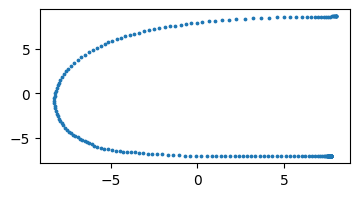

In [43]:
fig = plt.figure(figsize=(4,2))
plt.scatter(demos[2][:, 0], demos[2][:, 1], s=3)

### Place all points on a Sphere

In [44]:
demos = [d['pos'][0][0].T for d in data['demos'][0]]
demos = np.array(demos)
demos = 2 * demos / (np.max(demos, axis=1) - np.min(demos, axis=1))[:, None, :]
demos = np.concatenate((demos, np.ones((demos.shape[0], demos.shape[1], 1))), axis=2)
demos = demos / np.linalg.norm(demos, axis=2)[:, :, None]

### Input: Current position, Output: Next position

In [45]:
demos2 = demos[:, :-1, :]
target = demos[:, 1:, :]

In [46]:
print(demos2.shape, target.shape)

(14, 199, 3) (14, 199, 3)


In [47]:
nb_data = demos2.shape[1]
nb_data_sup = 50
nb_samples = 5

X = demos2[0]
for i in range(1, nb_samples):
    X = np.vstack([X, demos2[i]])
Y = target[0]
for i in range(1, nb_samples):
    Y = np.vstack([Y, target[i]])

In [48]:
print(X.shape, Y.shape)

(995, 3) (995, 3)


### Visualize Input

In [49]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
        mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                      X[p * nb_data:(p + 1) * nb_data, 1],
                      X[p * nb_data:(p + 1) * nb_data, 2],
                      color=(0.5, 0., 0.5),
                      scale_factor=0.02)
mlab.view(30, 30)
mlab.show()

### Visualize Output (well they share the same data points)

In [10]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
        mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
                      Y[p * nb_data:(p + 1) * nb_data, 1],
                      Y[p * nb_data:(p + 1) * nb_data, 2],
                      color=(0.2, 0.5, 0.),
                      scale_factor=0.02)
mlab.view(30, 30)
mlab.show()

In [50]:
# Data in format compatible with pymanopt product of manifolds
data = np.empty((X.shape[0], 2), dtype=object)
for n in range(nb_data*nb_samples):
    data[n] = [X[n], Y[n]]

data = np.array(data, dtype=object)

In [52]:
input_dim = 3
output_dim = 3

# Create the manifold
input_manifold = Sphere(input_dim)
output_manifold = Sphere(output_dim)
manifold = Product([input_manifold, output_manifold])

### Train ManifoldGMM

In [53]:
nb_clusters = 3

# K-means
km_means, km_assignments = manifold_k_means(manifold, data, nb_clusters=nb_clusters)

# GMM
initial_covariances = np.concatenate(nb_clusters * [np.eye(input_dim+output_dim)[None]], 0)
initial_priors = np.zeros(nb_clusters)
for k in range(nb_clusters):
    initial_priors[k] = np.sum(km_assignments == k) / nb_data
gmm_means, gmm_covariances, gmm_priors, gmm_assignments = manifold_gmm_em(manifold, data, nb_clusters,
                                                                          initial_means=km_means,
                                                                          initial_covariances=initial_covariances,
                                                                          initial_priors=initial_priors
                                                                          )
np.savez('gmm_sphere2.npz', gmm_means=gmm_means, gmm_covariances=gmm_covariances, gmm_priors=gmm_priors)

Converged after 10 iterations: 3.073e+01


### Evaluate GMM

### Start with a first point of a trajectory from the dataset and sample and keep track of the output from the learned GMM

In [54]:
rand_idx = 0
x0 = np.copy(X[rand_idx, :])
new_x = x0
sampled_path = [new_x]
dt = 1
for i in range(199):
    x_dot, sigma_gmr, H = manifold_gmr(new_x.reshape(1, -1), manifold, gmm_means, gmm_covariances, gmm_priors)
    new_x = x_dot[0]
    sampled_path.append(new_x)
sampled_path = np.array(sampled_path)

### Visualize learned GMM means (input and outuput states), sampled points (Green)

In [55]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
plot_sphere(figure=fig)
# Plot target data on the sphere
for p in range(nb_samples):
        mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
                      Y[p * nb_data:(p + 1) * nb_data, 1],
                      Y[p * nb_data:(p + 1) * nb_data, 2],
                      color=(0.5, 0., 0.5),
                      scale_factor=0.02)

# Plot sampled points
for p in range(len(sampled_path)):
    mlab.points3d(sampled_path[p, 0], sampled_path[p, 1], sampled_path[p, 2],
                  color=(0., 0.6, 0.),
                  scale_factor=0.03)

# Plot Input (Red) and Output (Green) Gaussians
for k in range(nb_clusters):
    plot_gaussian_mesh_on_tangent_plane(gmm_means[k, 0], gmm_covariances[k, :3, :3], color=(1, 0, 0))
    
for k in range(nb_clusters):
    plot_gaussian_mesh_on_tangent_plane(gmm_means[k, 1], gmm_covariances[k, 3:, 3:], color=(0, 1, 0))


mlab.view(30, 120)
# mlab.savefig('Figure0.png')
mlab.show()